# C3 metacalibration on a grid


In this notebook we process the rendered galaxy catalogs using the sextractor software, and transport them into a multi-epoch data system, which will later be used to interface with metacalibration


## Objectives

    1 run a minimal version of metacalibration
    
    2 recover constant shear from a grid of postage stamps
 

**TODO** Check the weight map, with someone expert


## Setup

This notebook relies on the:

    * synthetic package & dependencies
    
    * prepared & curated DC2 cutout data file


## Output

    * Recovered constant shear :)
    
The output files are placed in the `./data/` folder


## Contact

In case of questions, contact me at t.varga@physik.lmu.de

In [1]:
import fitsio as fio
import numpy as np
import pandas as pd
import pickle as pickle
import copy
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import galsim
import astropy.cosmology as cosmology

import images # package from erin sheldon

import synthetic.tools as tools
import synthetic.render.frame as frame
import synthetic.render.render as render
import synthetic.mcal as mcal


import meds
import psfex # The python wrapper

pixel_scale = 0.2

# Create a rendered image we are going to work on

and run source extractor

This part reproduces where largely identical to the B2 left off

In [2]:
# File path for input DC2 files
in_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/" 
# output path for mock image, be sure to place it into 
out_path = "data/"

Now we make a grid of roughly similar galaxies. They are defined in a similar parameter space as teh mock catalogs in the B1, B2 notebooks

We will add a constant amount of e1, e2 shear into this image to each galaxy, and then aim to recover it with the metacalibration method

In [3]:
shear1 = 0.03
shear2 = -0.02

shape_std=0.2  # shape noise of the mock galaxy catalog

ra_cen = 50.64516228577292 # RA center of mock pointing [deg]
dec_cen = -40.228830895890404 # DEC center of mock pointing [deg]


In [4]:
np.random.seed(23000)


nobjects = 10000
canvas_size = 10000
padding = 100
mock_catalog = pd.DataFrame()


x = np.linspace(padding, canvas_size - padding, 100)
y = np.linspace(padding, canvas_size - padding, 100)
xx, yy = np.meshgrid(x, y)
xx = xx.flatten()
yy = yy.flatten()


# this is something of an artifact, the X, Y is starting at 0, not at the image center... might need to be fixed
mock_catalog["X"] = xx
mock_catalog["Y"] = yy
lsizes = np.random.normal(loc=0.4, scale=0.2, size=nobjects)
mock_catalog["TSIZE"] = 10 
mock_catalog["FRACDEV"] = 0 #np.random.uniform(0, 1, size=nobjects)
mock_catalog["MAG_I"] = 21 #np.random.normal(loc=22, scale=0.5, size=nobjects)
mock_catalog["FLUX_I"] = tools.toflux(mock_catalog["MAG_I"])
mock_catalog["G1"] = np.random.normal(loc=0, scale=shape_std, size=nobjects) + shear1
mock_catalog["G2"] = np.random.normal(loc=0, scale=shape_std, size=nobjects) + shear2

g1 = mock_catalog["G1"]
g2 = mock_catalog["G2"]
amp = np.sqrt(g1**2 + g2**2) 

ii = amp > 0.8
mock_catalog.loc[ii, 'G1'] *= 0.8 / amp[ii]
mock_catalog.loc[ii, 'G2'] *= 0.8 / amp[ii]

# amp = np.sqrt(g1**2 + g2**2) 


# Preparing the grid of postage stamps

## Creating a deeper, detection image and weight map

source detection is traditionally done on coadded images, even when shear estimation is performed per-frame for greater performance.

For this reason, unlike in B1, B2, B3, we are going to create a single, deeper, detection frame

In [5]:
band = 'i'
name = out_path + 'test_canvas_' + band
print(name)
fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=1., canvas_size=canvas_size, config_se='data/configs/config.sex')
fr.render() 

data/test_canvas_i
starting postage stamp calculations in 100 processes


we also have to create a weight map

**TODO** check the actual values for this!!!

In [6]:
noise = np.ones(shape=(fr.canvas_size, fr.canvas_size)) # this is set as 1, as in this example that's the noise std
wcanvas = galsim.ImageF(noise, wcs=fr.canvas.wcs)
wcanvas.write(name + '_weight.fits', clobber=True)

after rendering, we can run sextractor, and load the results as

In [7]:
fr.extract()

sex data/test_canvas_i.fits -c data/configs/config.sex -CATALOG_NAME data/test_canvas_i_cat.fits -CHECKIMAGE_NAME data/test_canvas_i_seg.fits


here we have access to the sextractor catalog, and the segmentation map

In [8]:
scat = fr.scat.copy()
seg = fio.read("data/test_canvas_i_seg.fits")

before we go further, let's see the grid of galaxy postage stamps

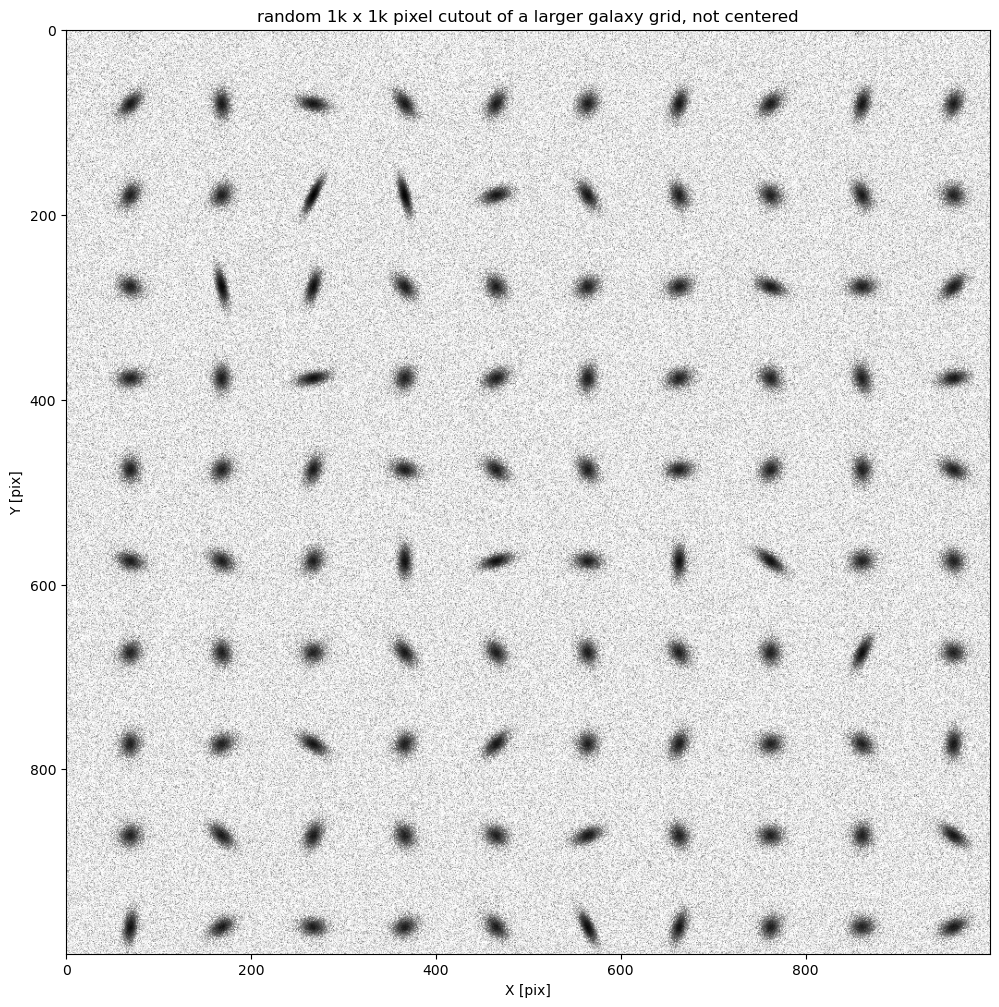

In [9]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

arr = fr.canvas.array[2000:3000, 3000:4000]
ax.imshow(np.arcsinh(arr) / arr, cmap=plt.cm.gray)
ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
ax.set_title('random 1k x 1k pixel cutout of a larger galaxy grid, not centered')
fig.savefig("data/grid_illustration.png", bbox_inches="tight")

## Creating a multi epoch data system file (MEDS)

See the C2 notebook

Now we are going to transform the synthetic image, into the multi epoch data system format, which is the last step before we can run metacalibration


In [10]:
objects = fr.scat.copy()

In [11]:
nimage = 1 # one exposure per object, we are simulating coadds with identical observational conditions
nobj = len(objects)
obj_data = meds.util.get_meds_input_struct(nobj, extra_fields=[("X_IMAGE", "f8"), ("Y_IMAGE", "f8")])
obj_data['id'] = objects['NUMBER'] # the source extractor ID, starts with 1, not 0...

# This the size of the bounding box for the object, should be adaptive based on the size of the source
box_sizes = np.round(objects["A_IMAGE"] * objects["B_IMAGE"] * 2 ) *2
box_sizes[box_sizes < 16] = 16 
obj_data['box_size'] = box_sizes

# The below are the positions of the source on the sky and in the image-
# The actual MEDS script uses the sky position based on the image WCS, but this is done completely under the hood
obj_data['ra'] = objects['ALPHAWIN_J2000'] + pixel_scale / 3600 # this is a hack for fortran vs python ordered arrays
obj_data['dec'] = objects['DELTAWIN_J2000'] - pixel_scale / 3600 # this is a hack for fortran vs python ordered arrays
obj_data['X_IMAGE'] = objects['X_IMAGE']
obj_data['Y_IMAGE'] = objects['Y_IMAGE']

In [12]:
path_image = fr.name + ".fits"
path_weight = fr.name + "_weight.fits"
path_seg = fr.name + "_seg.fits"

# Due to some memory reservation issues, we have to tell expicitely how long the longest filename will be.
path_length= np.max((len(path_image), len(path_seg), len(path_weight)))

image_info= meds.util.get_image_info_struct(nimage, path_length)

image_info['image_path'][0] = path_image
image_info['weight_path'][0] = path_weight
image_info['seg_path'][0] = path_seg
image_info['magzp'] = 30.

config = {'first_image_is_coadd': False,'cutout_types':['weight', 'seg'],'psf_type':'psfex'}

Since this is a synthetic image, we know the exact PSF, 

In reality this was estimated from a grid of stars in the same pipeline, however that is out of scope for this notebook

In [13]:
pex = psfex.PSFEx("/e/ocean1/users/vargatn/LSST/SYNTHETIC/star_canvas_cat.psf")
psf_data = [pex,]

now all is set for running the MEDSMaker

In [14]:
mm = meds.MEDSMaker(obj_data=obj_data, image_info=image_info, config=config, psf_data=psf_data)
mm.write(out_path + "grid.meds")

writing cutouts for: ['image', 'weight', 'seg']
file    1 of    1: 'b'data/test_canvas_i.fits''
    first cut:   10000 of  10000 objects
    second cut:  10000 of  10000 objects
10000/10000 had ncut > 0
setting start rows and pixel count
total pixels: 216213576
setting psf layout for PSFEx


/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/meds/util.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  phat = numpy.array([-1.0*sinp,cosp,0.0]).T


meds layout build time: 0.335670 seconds
opening output MEDS file: 'data/grid.meds'
writing object_data
writing image_info
writing metadata
    reserving image mosaic
    reserving weight mosaic
    reserving seg mosaic
    reserving psf mosaic
writing image cutouts
    1/1 image b'data/test_canvas_i.fits'
    no background for image
writing weight cutouts
    1/1 weight b'data/test_canvas_i_weight.fits'
writing seg cutouts
    1/1 seg b'data/test_canvas_i_seg.fits'
writing psf cutouts
output is in: data/grid.meds


now let's inspect the meds files, if all goes well, there should be a galaxy in each postage stamp cutout

In [15]:
m = meds.MEDS(out_path + "grid.meds")

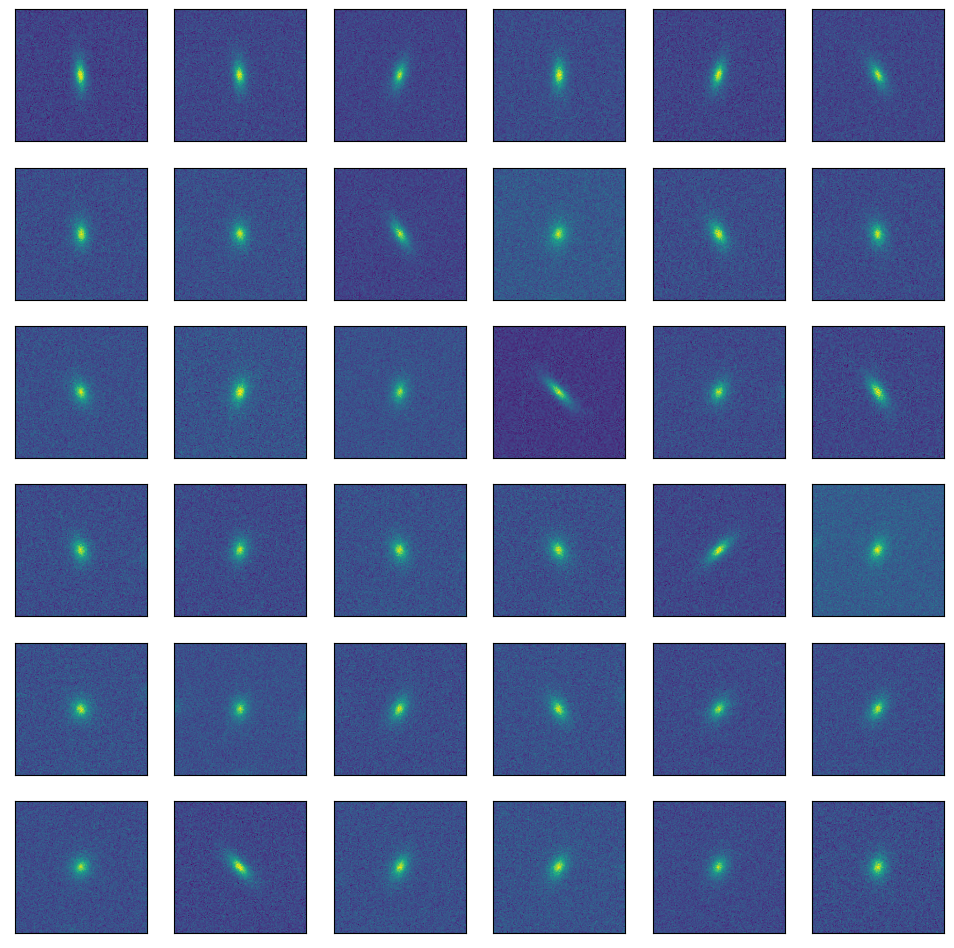

In [16]:
fig, axarr = plt.subplots(ncols=6, nrows=6, figsize=(12,12))
# fig.subplots_adjust(wspace=0.01)
for i, ax in enumerate(axarr.flatten()):
    im = m.get_cutout(i, 0, 'image')
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])    
fig.savefig("data/grid_illustration_meds.png", bbox_inches="tight")

# Running metacalibration

In [18]:
input_name = out_path + "grid.meds"

we have to prepare a set of instructions for the metacal runner

The actual calculation is split up to jobs, each processing a set of independent postage stamps, and the results are written to file

In [19]:
# The highest number of  objects to include from the sextractor detection catalog. 
maxnum = 40000 # for the example, you might be better off reducing the number from 10k down to fewer galaxies.

nprocess = 100 # the number of OpenMP processes you want to / are allowed to start

In [20]:
outfile_names = out_path + "grid_mcal" # file name root of output (will have additional _01 _02 etc appended to it)

infodicts = mcal.infomaker(maxnum, input_name, outfile_names, nchunk=nprocess)

In [21]:
mcal.multi_mcal(infodicts, nprocess=nprocess)

starting metacal calculations in 100 processes


Process ForkPoolWorker-113:
Process ForkPoolWorker-171:
Process ForkPoolWorker-181:
Process ForkPoolWorker-200:
Process ForkPoolWorker-108:
Process ForkPoolWorker-199:
Process ForkPoolWorker-122:
Process ForkPoolWorker-195:
Process ForkPoolWorker-180:
Process ForkPoolWorker-166:
Process ForkPoolWorker-177:
Process ForkPoolWorker-197:
Process ForkPoolWorker-170:
Process ForkPoolWorker-126:
Process ForkPoolWorker-148:
Process ForkPoolWorker-192:
Process ForkPoolWorker-169:
Process ForkPoolWorker-135:
Process ForkPoolWorker-103:
Process ForkPoolWorker-128:
Process ForkPoolWorker-163:
Process ForkPoolWorker-131:
Process ForkPoolWorker-140:
Process ForkPoolWorker-176:
Process ForkPoolWorker-158:
Process ForkPoolWorker-144:
Process ForkPoolWorker-142:
Process ForkPoolWorker-168:
Process ForkPoolWorker-157:
Process ForkPoolWorker-143:
Process ForkPoolWorker-159:
Process ForkPoolWorker-101:
Process ForkPoolWorker-124:
Process ForkPoolWorker-115:
Process ForkPoolWorker-133:
Process ForkPoolWork

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/moon/vargatn/anaconda3/

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._targ

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/pyth

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocess

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/moon/vargatn/anaconda3/env

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/mcal.py", line 333, in call_chunks
    run_

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/mcal.py", line 313, in run_mcal
    fitter.fit_obj(iobj, pars=pars, vb=vb)
  File "/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/mcal.py", line 313, in run_mcal
    fitter.fit_obj(iobj, pars=pars, vb=vb)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/mcal.py", line 333, in call_chunks
    run_mcal(info)
  File "/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/mcal.py", line 313, in run_mcal
    fitter.fit_obj(iobj, pars=pars, vb=vb)
  File "/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/mcal.py", line 313, 

  File "/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/mcal.py", line 268, in fit_obj
    ntry=ntry, metacal_pars=metacal_pars)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 1365, in fit_metacal
    guesser=guesser,
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 1365, in fit_metacal
    guesser=guesser,
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 1365, in fit_metacal
    guesser=guesser,
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 1365, in fit_metacal
    guesser=guesser,
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return se

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 539, in fit_max
    guess_widths=guess_widths)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 539, in fit_max
    guess_widths=guess_widths)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 539, in fit_max
    guess_widths=guess_widths)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 1373, in _get_all_metacal
    return metacal.get_all_metacal(self.mb_obs_list, **metacal_pars)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/metacal.py", line 94, in get_all_metacal
    odict = _get_all_metacal_fixnoise(obs, step=step, **kw)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 1373, in _get_all_metacal
    return metacal.get_all_metacal(self

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 2416, in go
    method(ntry=ntry)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/metacal.py", line 229, in _get_all_metacal_fixnoise
    obsdict = _get_all_metacal(obs, step=step, **kw)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/metacal.py", line 230, in _get_all_metacal_fixnoise
    noise_obsdict = _get_all_metacal(noise_obs, step=step, **kw)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 2416, in go
    method(ntry=ntry)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 766, in fit_gal_psf_flux
    fitter.go()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/bootstrap.py", line 473, in _fit_one_psf_max
    runner.go(ntry=ntry)
  File "/home/moon/vargatn/anaconda3/envs

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/fitting.py", line 1682, in go
    **self.lm_pars
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/astropy/table/table.py", line 2171, in add_column
    elif (col.shape == () or col.shape[0] == 1) and len(self) > 0:
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/metacal.py", line 1507, in _make_metacal_mb_obs_list_dict
    odict = _make_metacal_obs_list_dict(obs_list, step, **kw)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/fitting.py", line 1682, in go
    **self.lm_pars
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/fitting.py", line 1682, in go
    **self.lm_pars
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/metacal.py", line 1507, in _make_metacal_mb_obs_list_dict
    odict = _make_metacal_obs_list_dict(obs_list, step, **kw)
  Fi

Caught KeyboardInterrupt, terminating workers


  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/metacal.py", line 1507, in _make_metacal_mb_obs_list_dict
    odict = _make_metacal_obs_list_dict(obs_list, step, **kw)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/fitting.py", line 1682, in go
    **self.lm_pars
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/metacal.py", line 1522, in _make_metacal_obs_list_dict
    todict = _get_all_metacal(obs, step=step, **kw)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/metacal.py", line 1507, in _make_metacal_mb_obs_list_dict
    odict = _make_metacal_obs_list_dict(obs_list, step, **kw)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/fitting.py", line 2056, in run_leastsq
    lm_tup = leastsq(func, guess, full_output=1, **keys)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/fitting.py

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/gmix.py", line 586, in _fill_image
    fast_exp,
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/leastsqbound.py", line 281, in leastsqbound
    ftol, xtol, gtol, maxfev, epsfcn, factor, diag)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/metacal.py", line 385, in get_all
    get_unsheared=True
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/scipy/optimize/minpack.py", line 424, in leastsq
    gtol, maxfev, epsfcn, factor, diag)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/scipy/optimize/minpack.py", line 424, in leastsq
    gtol, maxfev, epsfcn, factor, diag)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/leastsqbound.py", line 281, in leastsqbound
    ftol, xtol, gtol, maxfev, epsfcn, factor, diag)
  File "/home/moon/vargatn/anaconda3/e

KeyboardInterrupt
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/fitting.py", line 1816, in _calc_fdiff
    start,
KeyboardInterrupt
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/numba/core/dispatcher.py", line 416, in _compile_for_args
    argtypes.append(self.typeof_pyval(a))
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/metacal.py", line 417, in get_obs_galshear
    sheared_image = self.get_target_image(newpsf_obj, shear=shear)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/metacal.py", line 465, in get_obs_psfshear
    conv_image = self.get_target_image(newpsf_obj, shear=None)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/metacal.py", line 580, in get_target_image
    method='no_pixel',
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/fitting.py", line 1816, in _calc_fdiff
 

  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/galsim/transform.py", line 520, in _drawKImage
    self._sbp.drawK(image._image, image.scale)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/galsim/utilities.py", line 1701, in f
    return self.mthd(obj, *args, **kwargs)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/numba/core/compiler_lock.py", line 20, in __enter__
    self.acquire()
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/numba/core/typing/typeof.py", line 244, in _typeof_ndarray
    dtype = numpy_support.from_dtype(val.dtype)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/galsim/utilities.py", line 1701, in f
    return self.mthd(obj, *args, **kwargs)
  File "/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/numba/core/typing/typeof.py", line 38, in typeof
    ty = typeof_impl(val, c)
  File "/home/moon/vargatn

KeyboardInterrupt: 

now we need to read in the results from file

In [ ]:
tab = mcal.collater(infodicts)

In [ ]:
gest1_raw =tab["g_noshear"][:, 0].mean()
gest2_raw =tab["g_noshear"][:, 1].mean()

gest1 =tab["g_noshear"][:, 0].mean() / tab['r11'].mean()
gest2 =tab["g_noshear"][:, 1].mean() / tab['r22'].mean()



In [ ]:
print("the measured shape  <e> with",maxnum ,"galaxies")
print("g1 = {:.4f}".format(gest1_raw), "the input shape is", shear1)
print("g2 = {:.4f}".format(gest2_raw), "the input shape is", shear2)
print('')
print('METACALIBRATION:')
print("the measured shape  <e> / <R> with",maxnum ,"galaxies")
print("g1 = {:.4f}".format(gest1), "the input shape is", shear1)
print("g2 = {:.4f}".format(gest2), "the input shape is", shear2)

In [147]:
print(tab["g1_MC"].mean() / tab['r11'].mean())
# print(tab["g2_MC"].mean())

0.026228463511629954
